# David Centeno Pedrido - Python, Deep Learning (CNN), image modelling

In this Notebook, we will try to solve a regression problem with image data using keras and different approach related to this type of situations.

The dataset that we will use consists of 1027 images of food trays we have information about the percentage of pixels that correspond to food. Our job will be to train a neural network capable of, from an image of a food tray, being able to determine the percentage of pixels that will correspond to food.

During the work we will try to solve the problem from three different points of view:
- Creation of a complete CNN
- Transfer learning: Use of pre-trained network as a feature extractor
- Transfer learning: Fine-tunning

In each section we will comment on each of these three approaches in more depth. First we will carry out the process of preparing the dataset that will be common to all models.

We will divide the dataset into training|test|validation and use the same partition to train, validate and test each of the models in the fairest way possible.

We will also use data augmentation techniques using horizontal flip, vertical flip and changing the brightness of the images in order to increase the size of the dataset.

### 1. Libraries

First of all, we are going to do is load the necessary modules from various libraries, among which are Keras (The Python Deep Learning library) and Scikit-learn (Machine learning in Python).

In [ ]:
%tensorflow_version 1.x

import pandas as pd
import numpy as np

from google.colab import drive
from sklearn.model_selection import train_test_split

from keras import applications
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV

import itertools
import seaborn as sns
import random
import math
import tensorflow as tf

import matplotlib.pyplot as plt

TensorFlow 1.x selected.


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 2. Getting ready the data

As we said, in this example we are going to use an image classification set called ** UNIMIB2016 **, which contains 1027 images of food trays, of which we know the percentage of pixels that correspond to food. Our job will be to train a neural network capable of, from an image of a food tray, being able to determine the percentage of pixels that will correspond to food. More info and download [here](http://www.ivl.disco.unimib.it/activities/food-recognition/).

Inside the .zip, we can find this:

*   A folder **images** with 1027 images
*   A file **percentage.csv** with the percentage of pixels that correspond to food

Next, we will use the Scikit-learn *train_test_split* method to divide the data into three partitions: **train, validation and test**. In this example, we have used 64% of the images for training, 16% for validation and 20% for testing.

Finally, we will use the *ImageDataGenerator()* and *flow_from_dataframes()* methods to generate image batches.

We will perform the data augmentation process with the flips and the change in brightness and we will also use the plotImages function to be able to visualize these dataset augmentation processes.

In [ ]:
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/My Drive/Colab Notebooks/DL_UNIMIB2016.zip' >> /dev/null
data_path = 'UNIMIB2016/'
imgs_path = data_path + "images/"
labels_path = data_path + "percentage.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# read the .csv with the labels
labels = pd.read_csv(labels_path)

# data partition
seed = 0
train_data, test_data = train_test_split(labels, test_size=0.2, random_state=seed)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=seed)

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

datagen = ImageDataGenerator(rescale=1./255, horizontal_flip = True, vertical_flip = True, channel_shift_range = 100)

img_width = 640
img_height = 480 
x_col = 'image_name'          
y_col = 'food_pixels'

# batch generator
batch_size = 1              
train_generator = datagen.flow_from_dataframe(dataframe=train_data, directory=imgs_path, x_col=x_col, y_col=y_col,
                                              class_mode="raw", target_size=(img_width,img_height),
                                              batch_size=batch_size) #train
dev_generator = datagen.flow_from_dataframe(dataframe=val_data, directory=imgs_path, x_col=x_col, y_col=y_col,
                                          class_mode="raw", target_size=(img_width,img_height),
                                          batch_size=batch_size) #val
test_generator = datagen.flow_from_dataframe(dataframe=test_data, directory=imgs_path, x_col=x_col, y_col=y_col,
                                             class_mode="raw", target_size=(img_width,img_height),
                                             batch_size=batch_size) #test

Found 656 validated image filenames.
Found 165 validated image filenames.
Found 206 validated image filenames.


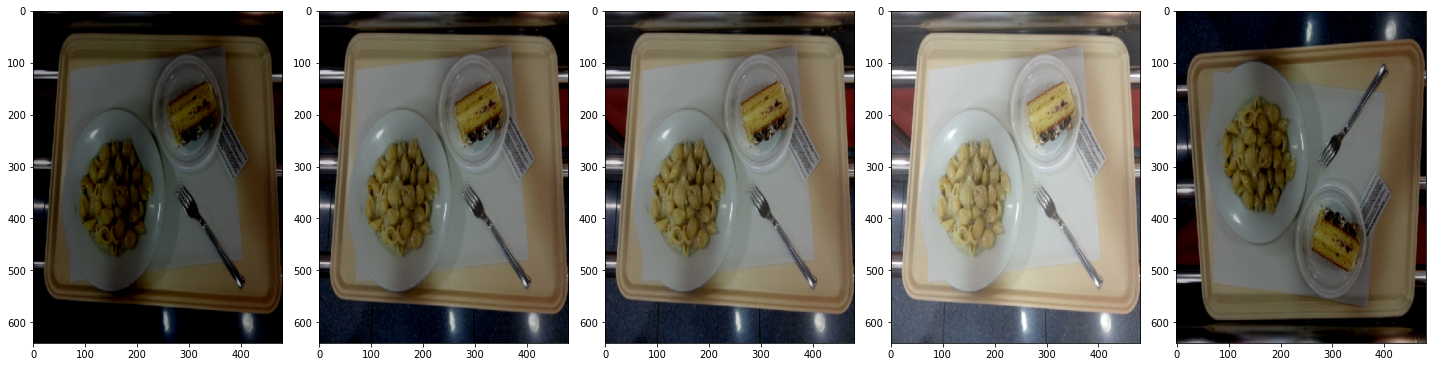

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

## 3. First approach: creation of a full CNN from scratch

In this section we are going to generate complete CNNs to solve the regression problem. To do this we are going to test different combinations to try to find the set of parameters that best solve our problem.

We will generate a hyperparameter grid for this purpose in the function *parameter_grid_full_CNN*. This function generates a pseudo-random grid because the continuous hyperparameter learning_rate is generated randomly for each experiment, taking a value within the interval (0.001, 0.00005).

In *create_model* we create and train each of the experiments we perform. The results are finally saved in the dataset vals, which contains each of the hyperparameters of the model, all the information collected in the training history and also the RMSE value applying the model on the test set. For comparison purposes, we will use as baseline RMSE = 4.8.

In [ ]:
def optimizer_selection(opt, lr):
    if opt == 'Adam':
        return optimizers.Adam(lr=lr)
    elif opt == 'RMSprop':
        return optimizers.RMSprop(lr=lr)

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def parameter_grid_full_CNN():
    random.seed(0)
    optimizer = ['Adam', 'RMSprop']
    n_neurons = [32, 64]
    activation = ['relu', 'tanh']
    batch_size = [25]
    init = ['normal', 'glorot_normal']
    dropout_rate = [0.5]
    filters = [16]
    kernel_size = [3]
    prueba = dict(optimizer = optimizer, n_neurons = n_neurons, 
                  activation = activation,
                  batch_size = batch_size, init = init,
                  dropout_rate = dropout_rate, 
                  filters = filters, kernel_size = kernel_size)
    keys, values = zip(*prueba.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]
    # random learning rate
    _ = [item.update({"learning_rate":random.uniform(0.001, 0.00005)}) for item in experiments]   
    return experiments

def create_model(n_neurons = 32, activation = 'relu', optimizer = 'Adam', batch_size = 1, init = 'normal',
                 dropout_rate = 0.5, learning_rate = 0.001, filters = 16, kernel_size = 3):
    
    model = Sequential()

    model.add(Conv2D(filters, kernel_size, activation='relu', input_shape=(img_width,img_height,3)))
    model.add(Conv2D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_neurons, activation=activation, kernel_initializer = init))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_neurons, activation=activation, kernel_initializer = init))
    model.add(Dense(1))

    model.compile(loss=root_mean_squared_error, metrics=[root_mean_squared_error],    
                  optimizer=optimizer_selection(optimizer, learning_rate))
    
    # early stopping
    callbacks = EarlyStopping(monitor = 'val_loss', min_delta=0.0001, patience=5, verbose = 0, mode = 'auto')

    history = model.fit_generator(train_generator,
                    epochs=25,  
                    verbose=2,  
                    steps_per_epoch=len(train_data)/batch_size,
                    validation_data=dev_generator,
                    validation_steps=len(val_data)/batch_size,
                    callbacks=[callbacks])
    return history.history, model

In [ ]:
experiments = parameter_grid_full_CNN()
training_history = []
model_losses = []
model_RMSE = []
for experiment in experiments:
    print(experiment)
    try:
        res, model = create_model(**experiment)
        training_history.append(res)
        test_loss, test_RMSE = model.evaluate_generator(test_generator,
                                               steps=len(test_data)/batch_size,
                                               verbose=1)
        model_losses.append(test_loss)
        model_RMSE.append(test_RMSE)
        del model
        K.clear_session()

    except:
        training_history.append('failed')
        model_losses.append('failed')
        model_RMSE.append('failed')
        

vals = pd.DataFrame(experiments)
vals['training_history'] = training_history
vals['model_losses'] = model_losses
vals['model_RMSE'] = model_RMSE

{'optimizer': 'Adam', 'n_neurons': 32, 'activation': 'relu', 'batch_size': 25, 'init': 'normal', 'dropout_rate': 0.5, 'filters': 16, 'kernel_size': 3, 'learning_rate': 0.0001977992410512043}
Epoch 1/25
 - 1s - loss: 8.7317 - root_mean_squared_error: 8.7317 - val_loss: 9.5391 - val_root_mean_squared_error: 7.9831
Epoch 2/25
 - 1s - loss: 6.5183 - root_mean_squared_error: 6.5183 - val_loss: 2.0374 - val_root_mean_squared_error: 4.7007
Epoch 3/25
 - 1s - loss: 8.2067 - root_mean_squared_error: 8.2067 - val_loss: 13.3910 - val_root_mean_squared_error: 4.7420
Epoch 4/25
 - 1s - loss: 7.3812 - root_mean_squared_error: 7.3812 - val_loss: 1.0178 - val_root_mean_squared_error: 9.5744
Epoch 5/25
 - 1s - loss: 7.5639 - root_mean_squared_error: 7.5639 - val_loss: 0.9024 - val_root_mean_squared_error: 5.7593
Epoch 6/25
 - 1s - loss: 6.5138 - root_mean_squared_error: 6.5138 - val_loss: 5.3906 - val_root_mean_squared_error: 6.1744
Epoch 7/25
 - 1s - loss: 8.6653 - root_mean_squared_error: 8.6653 - va

In [ ]:
vals = pd.DataFrame(experiments)
vals['training_history'] = training_history
vals['model_losses'] = model_losses
vals['model_RMSE'] = model_RMSE
vals = vals[vals.model_RMSE != 'failed']
vals = vals.sort_values(by=['model_RMSE'])

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Once we have the *vals* dataset created, we will visualize the RMSE values we have obtained on the test set and compare it with the 4.8 baseline with a visualization. 

Then we are going to choose the 4 trainings that give us the best values to analyze how the training process has gone, also, we will choose the best model to compare it with the ones from other approaches.

This process will be repeated in each of the three approaches proposed in the work.

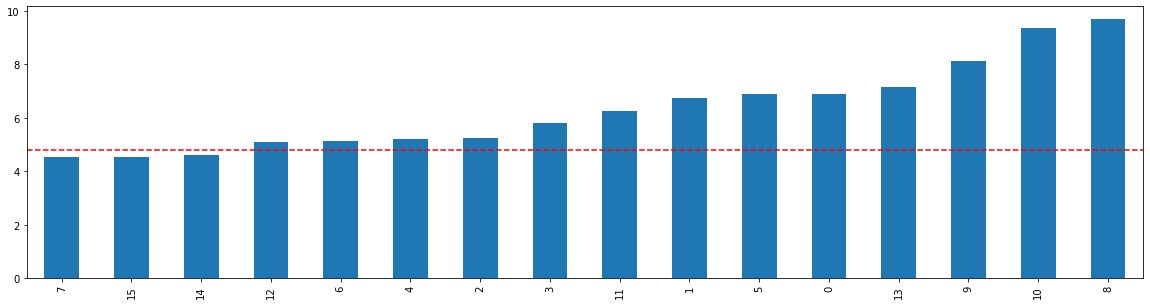

In [ ]:
plt.rcParams['figure.figsize'] = [20, 5]

ax = vals.model_RMSE.plot(kind='bar')
ax.axhline(4.8, color="red", linestyle="--")

It's easy to find out that the first 3 models presented have a lower RMSE than the one marked as baseline.

Let's choose the 4 best models to see how they behaved during the training:

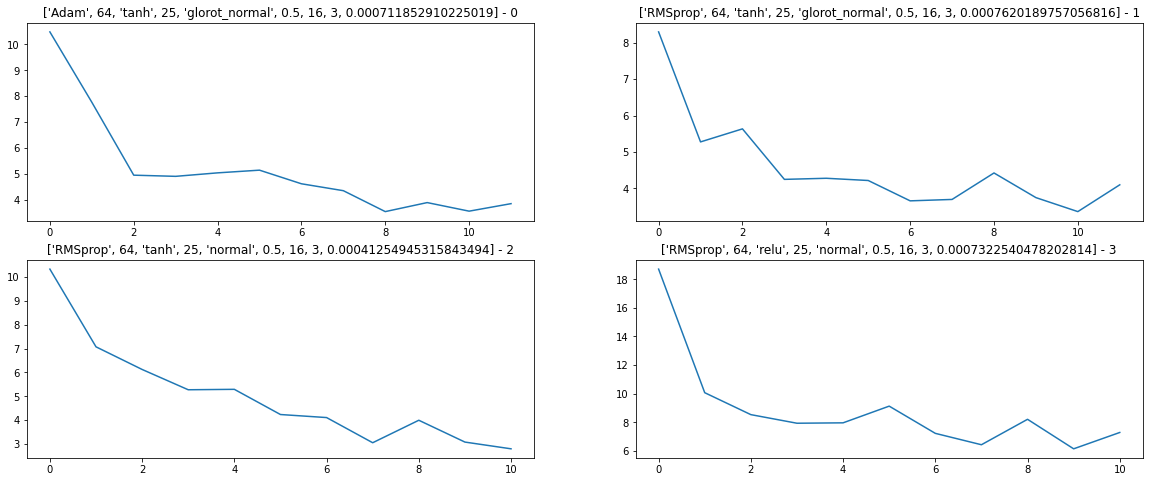

In [ ]:
fig, axs = plt.subplots(2, 2)
plt.rcParams['figure.figsize'] = [20, 8]
vals = vals.sort_values(by=['model_RMSE'])

k = 0
for i in range(2):
    for j in range(2):
        axs[i, j].plot(vals.training_history[vals.index[k]]['loss'])
        axs[i, j].set_title(str(list(experiments[vals.index[k]].values()))+' - ' + str(k))
        k += 1

All the trainings seems to have a correct behaviour over the test dataset, making us confident on not falling on overfitting.

The training shown in the upper left position was the one that showed the best RMSE over the test set, being this RMSE = 4.5, improving in 0.3 the proposed baseline, and the training seems to have happened correctly, so we will consider it the best model in this section.

This are the params of this best model:

In [ ]:
vals.iloc[[0]]

,optimizer,n_neurons,activation,batch_size,init,dropout_rate,filters,kernel_size,learning_rate,training_history,model_losses,model_RMSE
7,Adam,64,tanh,25,glorot_normal,0.5,16,3,0.000712,"{'val_loss': [12.948149681091309, 3.8014321327...",3.450053,4.508306


## 3. Second approach: Transfer learning - pretrained net as feature extractor

An alternative to creating a CNN and training it from scratch is to use pre-trained models with large data sets. This process is called transfer learning. In this example, we are going to use the InceptionV3 model pretrained with ImageNet.

To the base model we will add some final layers that are totally connected and that will serve to solve our regression problem.

For this process we are going to do grid search on 3 hyperparameters, due to the great computational load that this type of training requires. The grid is going to test over different combinations of optimizer, number of neurons and activation functions, all defined in the *generate_experiments_parameters* function.

In [ ]:
def generate_experiments_parameters():
    optimizer = ['Adam', 'RMSprop']
    n_neurons = [512, 1024]
    activation = ['relu', 'tanh']
    experiments = dict(optimizer = optimizer, n_neurons = n_neurons, 
                  activation = activation)
    keys, values = zip(*experiments.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]
    return experiments

def optimizer_selection(opt):
    if opt == 'Adam':
        return optimizers.Adam(lr=0.00001)
    elif opt == 'RMSprop':
        return optimizers.RMSprop(lr=0.00001)

def create_model_TL(n_neurons = 1024, activation = 'relu', optimizer = 'Adam'):
    base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))

    # we don't update the params from InceptionV3 
    for layer in base_model.layers:
        layer.trainable = False   
    
    # adding more layers to solve our regression problem 
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(n_neurons, activation=activation)(x)
    x = Dropout(0.5)(x)
    # Last layer with only one neuron
    predictions = Dense(1)(x) 
    model = Model(inputs=[base_model.input], outputs=[predictions])
    
    
    model.compile(loss=root_mean_squared_error, metrics=[root_mean_squared_error],    
                  optimizer=optimizer_selection(optimizer))
    callbacks = EarlyStopping(monitor = 'val_loss', min_delta=0.0001, patience=5, verbose = 0, mode = 'auto')

    history = model.fit_generator(train_generator,
                        epochs=60,  
                        verbose=2,  
                        steps_per_epoch=len(train_data)/batch_size,
                        validation_data=dev_generator,
                        validation_steps=len(val_data)/batch_size,
                        callbacks=[callbacks])
    return history.history, model

In [ ]:
experiments = generate_experiments_parameters()
training_history = []
model_losses = []
model_RMSE = []
for experiment in experiments:
    print(experiment)
    try:
        res, model = create_model_TL(**experiment)
        training_history.append(res)
        test_loss, test_RMSE = model.evaluate_generator(test_generator,
                                               steps=len(test_data)/batch_size,
                                               verbose=1)
        model_losses.append(test_loss)
        model_RMSE.append(test_RMSE)
        del model
        K.clear_session()

    except:
        training_history.append('failed')
        model_losses.append('failed')
        model_RMSE.append('failed')

{'optimizer': 'Adam', 'n_neurons': 512, 'activation': 'relu'}

Epoch 1/60
 - 27s - loss: 6.2402 - root_mean_squared_error: 6.2402 - val_loss: 9.7075 - val_root_mean_squared_error: 4.7921
Epoch 2/60
 - 24s - loss: 4.0667 - root_mean_squared_error: 4.0667 - val_loss: 8.0161 - val_root_mean_squared_error: 4.7418
Epoch 3/60
 - 24s - loss: 3.9996 - root_mean_squared_error: 3.9996 - val_loss: 5.7022 - val_root_mean_squared_error: 4.6786
Epoch 4/60
 - 24s - loss: 3.9984 - root_mean_squared_error: 3.9984 - val_loss: 16.0995 - val_root_mean_squared_error: 4.7248
Epoch 5/60
 - 24s - loss: 3.8884 - root_mean_squared_error: 3.8884 - val_loss: 20.0971 - val_root_mean_squared_error: 4.5131
Epoch 6/60
 - 24s - loss: 4.0122 - root_mean_squared_error: 4.0122 - val_loss: 6.9616 - val_root_mean_squared_error: 4.5179
Epoch 7/60
 - 24s - loss: 4.1414 - root_mean_squared_error: 4.1414 - val_loss: 2.7618 - val_root_mean_squared_error: 4.6279
Epoch 8/60
 - 24s - loss: 4.0673 - root_mean_squared_error: 4.0673 

In [ ]:
vals_TF = pd.DataFrame(experiments)
vals_TF['training_history'] = training_history
vals_TF['model_losses'] = model_losses
vals_TF['model_RMSE'] = model_RMSE
vals_TF = vals_TF[vals_TF.model_RMSE != 'failed']
vals_TF = vals_TF.sort_values(by=['model_RMSE'])

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


As we did in the other case, we can compare all the results from the grid:

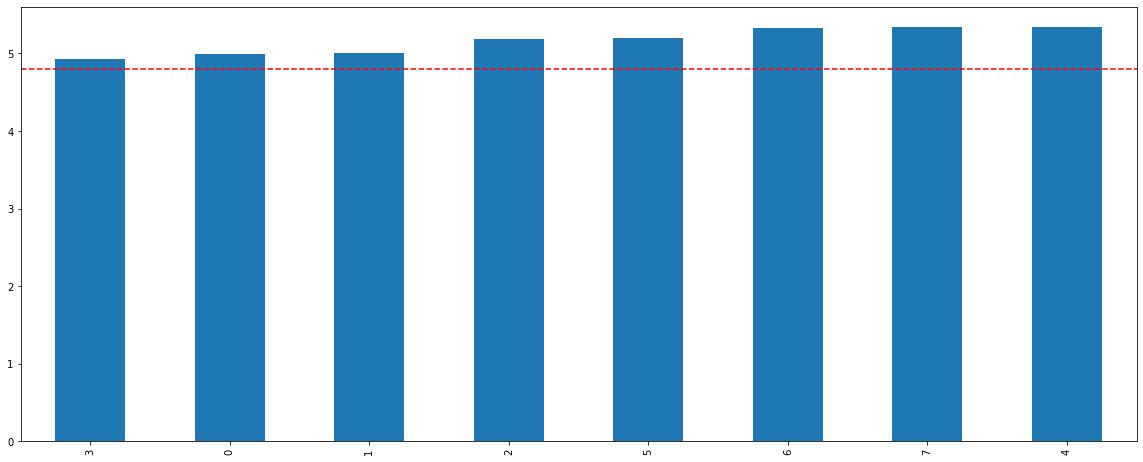

In [ ]:
ax = vals_fine_tunning.model_RMSE.plot(kind='bar')
ax.axhline(4.8, color="red", linestyle="--")

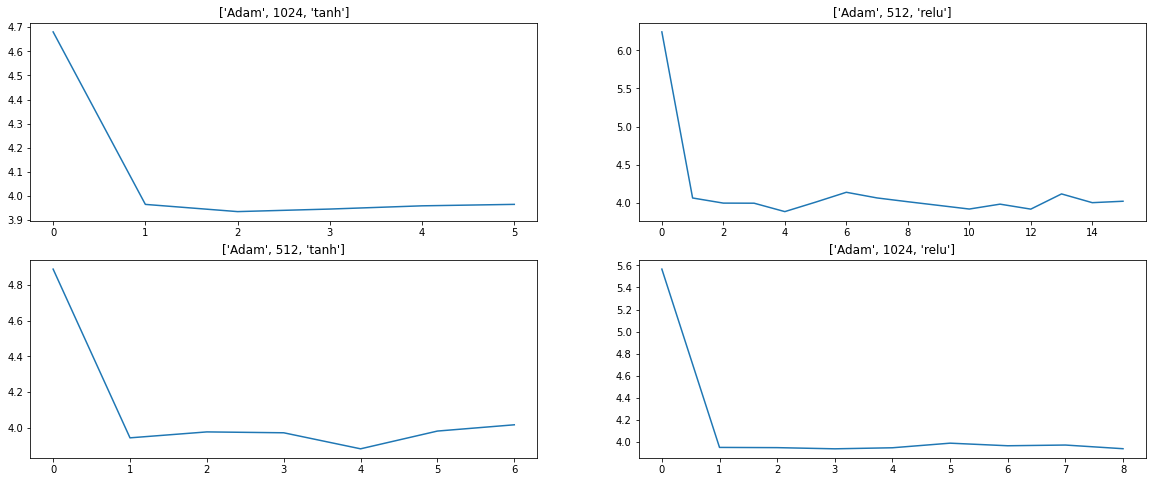

In [ ]:
fig, axs = plt.subplots(2, 2)

k = 0
for i in range(2):
    for j in range(2):
        axs[i, j].plot(vals_fine_tunning.training_history[vals_fine_tunning.index[k]]['root_mean_squared_error'])
        axs[i, j].set_title(str(list(experiments[vals_fine_tunning.index[k]].values())))
        k += 1

The best model, in the upper left part, seems to be stable in training from the first epoch, and is the one that behaves best on the test set, with an approximate value in the RMSE of 4.9, being higher than the proposed baseline and the model achieved in the first approach.

In [ ]:
vals_fine_tunning.iloc[[0]]

,optimizer,n_neurons,activation,training_history,model_losses,model_RMSE
0,Adam,1024,tanh,"{'val_loss': [3.310178756713867, 5.33322238922...",7.003496,4.934895


## 4. Third approach: Transfer learning - fine tuning

The other transfer learning approach that we will test is fine tuning: we will take a pretrained net and update all parameters on training. Also, we will add connected layers to solve the problem we're facing.

For this case we are going to use DenseNet121 trained with imagenet, despite being a very complete network, it only contains the order of 8 million parameters, which does not make it as big as others and will allow us to do different tests with hyperparameter configurations in a more agile way.

In [ ]:
def optimizer_selection(opt):
    if opt == 'Adam':
        return optimizers.Adam(lr=0.000001)
    elif opt == 'RMSprop':
        return optimizers.RMSprop(lr=0.000001)


def create_model_fine_tuning(n_neurons = 1024, activation = 'relu', optimizer = 'Adam'):
    base_model = applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))   
    # adding layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(n_neurons, activation=activation)(x)
    # one output layer - regression problem
    predictions = Dense(1)(x) 
    model = Model(inputs=[base_model.input], outputs=[predictions])
    
    
    model.compile(loss='mean_absolute_error', metrics=[root_mean_squared_error],    
                  optimizer=optimizer_selection(optimizer))
    
    # early stopping
    callbacks = EarlyStopping(monitor = 'val_loss', min_delta=0.0001, patience=5, verbose = 0, mode = 'auto')
    
    history = model.fit_generator(train_generator,
                        epochs=60,  
                        verbose=2,  
                        steps_per_epoch=len(train_data)/batch_size,
                        validation_data=dev_generator,
                        validation_steps=len(val_data)/batch_size,
                        callbacks=[callbacks])
    return history.history, model


In [ ]:
# same experiments than in second approach
training_history = []
model_losses = []
model_RMSE = []
for experiment in experiments:
    print(experiment)
    try:
        res, model = create_model_fine_tuning(**experiment)
        training_history.append(res)
        test_loss, test_RMSE = model.evaluate_generator(test_generator,
                                               steps=len(test_data)/batch_size,
                                               verbose=1)
        model_losses.append(test_loss)
        model_RMSE.append(test_RMSE)
        del model
        K.clear_session()

    except:
        training_history.append('failed')
        model_losses.append('failed')
        model_RMSE.append('failed')

{'optimizer': 'Adam', 'n_neurons': 512, 'activation': 'relu'}
29089792/29084464 [==============================] - 1s 0us/step
Epoch 1/60
 - 114s - loss: 11.8664 - root_mean_squared_error: 11.8664 - val_loss: 3.0828 - val_root_mean_squared_error: 10.1521
Epoch 2/60
 - 87s - loss: 7.9021 - root_mean_squared_error: 7.9021 - val_loss: 6.9519 - val_root_mean_squared_error: 6.9524
Epoch 3/60
 - 85s - loss: 5.6307 - root_mean_squared_error: 5.6307 - val_loss: 5.0482 - val_root_mean_squared_error: 5.4379
Epoch 4/60
 - 85s - loss: 4.5174 - root_mean_squared_error: 4.5174 - val_loss: 0.9743 - val_root_mean_squared_error: 4.6882
Epoch 5/60
 - 86s - loss: 4.0878 - root_mean_squared_error: 4.0878 - val_loss: 4.3207 - val_root_mean_squared_error: 4.2721
Epoch 6/60
 - 86s - loss: 3.9389 - root_mean_squared_error: 3.9389 - val_loss: 7.2643 - val_root_mean_squared_error: 4.1202
Epoch 7/60
 - 86s - loss: 3.8751 - root_mean_squared_error: 3.8751 - val_loss: 5.2601 - val_root_mean_squared_error: 4.0069
E

In [ ]:
vals_full_retrain = pd.DataFrame(experiments)
vals_full_retrain['training_history'] = training_history
vals_full_retrain['model_losses'] = model_losses
vals_full_retrain['model_RMSE'] = model_RMSE
vals_full_retrain = vals_full_retrain[vals_full_retrain.model_RMSE != 'failed']
vals_full_retrain = vals_full_retrain.sort_values(by=['model_RMSE'])

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


As we did in the other case, we can compare all the results from the grid:

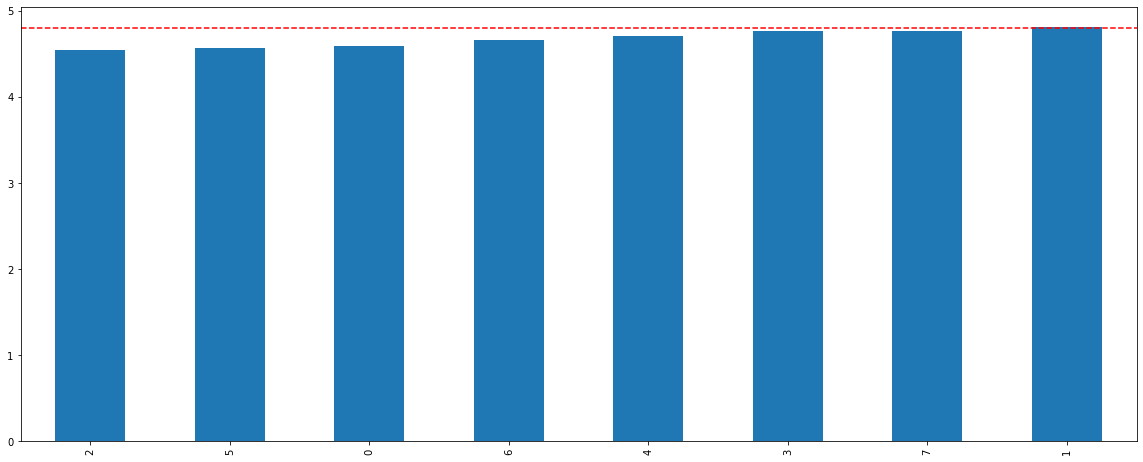

In [ ]:
ax = vals_full_retrain.model_RMSE.plot(kind='bar')
ax.axhline(4.8, color="red", linestyle="--")

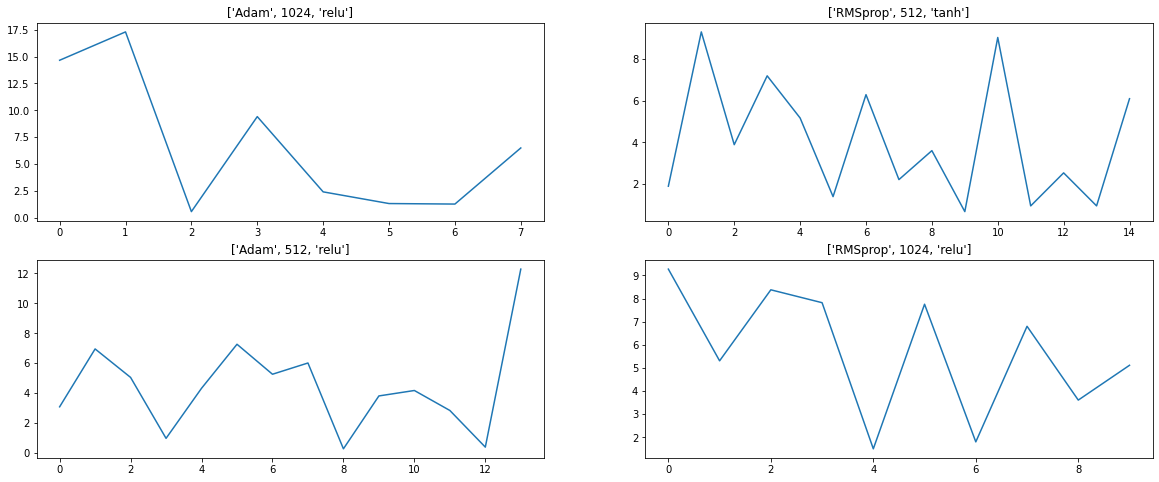

In [ ]:
fig, axs = plt.subplots(2, 2)

k = 0
for i in range(2):
    for j in range(2):
        axs[i, j].plot(vals_full_retrain.training_history[vals_full_retrain.index[k]]['val_loss'])
        axs[i, j].set_title(str(list(experiments[vals_full_retrain.index[k]].values())))
        k += 1


In this approach, the RMSE on the test data was not stable like in the other situations, this make us think that we should not trust this results. Testing more on this kind of approach would be advisable to if we want to use this solution.

By the way, the best RMSE was 4.5, which doesn't outperform the first approach.

In [ ]:
vals_full_retrain.iloc[[0]]

,optimizer,n_neurons,activation,training_history,model_losses,model_RMSE
2,Adam,1024,relu,"{'val_loss': [14.666614532470703, 17.309358596...",4.228937,4.539046


## 4. Conclusions

- We tested several models following 3 different ways of working with the CNNs: creating the model from scratch, using pre-trained network as feature extractor and fine-tuning.

- Building a CNN from scratch seemed the best solution since it had a very good behavior on test data and the best RMSE (4.5).

- The results from fine tunning are not determinant, since we didn't train an stable model and should keep testing over it.